In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
df = pd.read_csv('e:/machine learning/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]

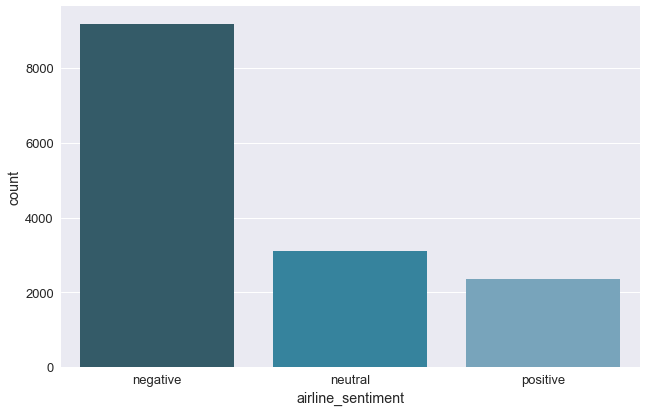

In [5]:
sns.factorplot(x="airline_sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [12]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['airline_sentiment'] = df.airline_sentiment

In [24]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show();

In [14]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [10]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

12222    glad rt bet bird wish flown south winter                         
3936     point upc code check baggag tell luggag vacat day tri swimsuit   
367      vx jfk la dirti plane not standard                               
12257    tell mean work need estim time arriv pleas need laptop work thank
2957     sure busi go els airlin travel name kathryn sotelo               
Name: text, dtype: object

In [15]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


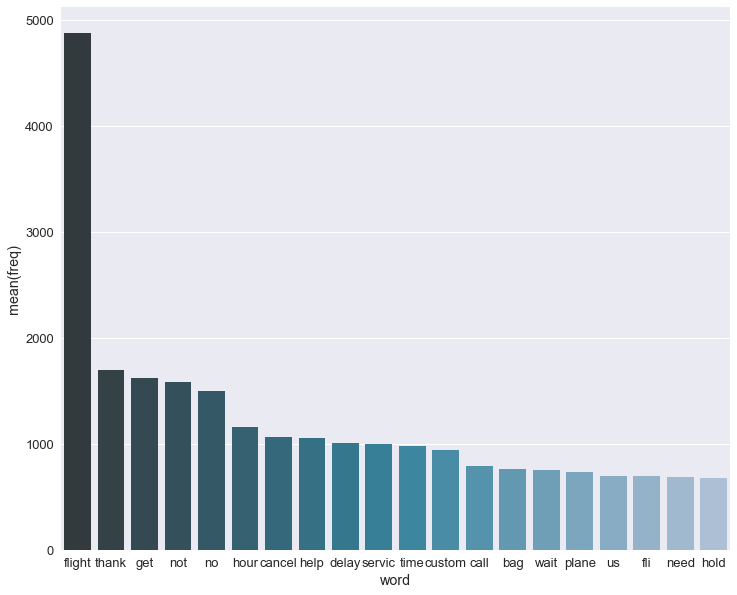

In [16]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show()

In [17]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_capital_words',
 'count_emojis',
 'count_excl_quest_marks',
 'count_hashtags',
 'count_mentions',
 'count_urls',
 'count_words',
 'airline_sentiment',
 'clean_text']

In [18]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [19]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [20]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [21]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [25]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_mnb_countvect, 'e:/machine learning/best_mnb_countvect.pkl')
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_logreg_countvect, 'e:/machine learning/output/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   47.7s finished


done in 49.354s

Best CV score: 0.776
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.91      0.86       911
     neutral       0.66      0.48      0.56       320
    positive       0.77      0.72      0.74       233

   micro avg       0.78      0.78      0.78      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.77      0.78      0.77      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


done in 186.650s

Best CV score: 0.795
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.811


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88       911
     neutral       0.73      0.53      0.62       320
    positive       0.80      0.74      0.77       233

   micro avg       0.81      0.81      0.81      1464
   macro avg       0.79      0.73      0.75      1464
weighted avg       0.81      0.81      0.80      1464



In [28]:
tfidfvect = TfidfVectorizer()
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_mnb_tfidf, '../output/best_mnb_tfidf.pkl')
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_logreg_tfidf, '../output/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


done in 77.964s

Best CV score: 0.748
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84       911
     neutral       0.76      0.29      0.42       320
    positive       0.80      0.50      0.62       233

   micro avg       0.75      0.75      0.75      1464
   macro avg       0.77      0.59      0.63      1464
weighted avg       0.76      0.75      0.72      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter alpha for estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist
, min_count=1
, size=SIZE
, window=5
, workers=4)
model.most_similar('plane', topn=3)

In [ ]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [ ]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
#joblib.dump(best_logreg_w2v, '../output/best_logreg_w2v.pkl')

In [27]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
, n_jobs=-1)
pipeline = Pipeline([
('features', features)
, ('clf', LogisticRegression(C=1.0, penalty='l2'))
])
best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)
# Applying on new positive tweets
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
,"Love flying with you guys ask these years. Sad that this will be the last trip ? @VirginAmerica #LuxuryTravel"
,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])
df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
best_model.predict(df_model_pos).tolist()
# Applying on new negative tweets
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])
df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg
best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']